In [1]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import functions.nominal_rigidity_network as nominal_rigidity_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 3: Multiple Major Occupations

We now allow for a more flexible occupation-sector structure, using occupation-by-sector employment data from [NEED TO FILL IN].  

In [2]:
A_spec = 1
data_dir = '../data/clean/'
dfTau    = pd.read_csv(data_dir + 'tau_2021.csv').sort_values(by=['short_names'])
dfepsN   = pd.read_csv(data_dir + 'epsN_2021.csv', index_col=0).sort_index(axis=1)
dfcurlyL = pd.read_csv(data_dir + 'curlyL_2021.csv', index_col=0).sort_index()
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors  = dfA['short_names']
dfDemand = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'short_names'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')
sector_names = list(dfA['short_names']) + ['Agg Y']
occupation_names = list(dfcurlyL.index)
dfepsN_weights = dfepsN.rename_axis('short_names').reset_index().melt(id_vars='short_names')

In [46]:
dfepsN.sum(axis=1)

Industry
accom       1.0
const       1.0
dur         1.0
edhealth    1.0
fin         1.0
gov         1.0
info        1.0
mining      1.0
nondur      1.0
other       1.0
profserv    1.0
trade       1.0
trans       1.0
dtype: float64

In [3]:
dfepsN_weights

,short_names,variable,value
0,accom,Admin,0.043469
1,const,Admin,0.068297
2,dur,Admin,0.061118
3,edhealth,Admin,0.077671
4,fin,Admin,0.183165
...,...,...,...
281,nondur,Trans,0.095610
282,other,Trans,0.061058
283,profserv,Trans,0.032131
284,trade,Trans,0.150072


In [4]:
dfTau.head()

,Industry,TOT_EMP,TOT_EMP_HR,Workers,Tau,short_names
6,Leisure and hospitality,13558650.0,21710.0,13536940.0,0.001604,accom
0,Construction,7368800.0,18050.0,7350750.0,0.002456,const
1,Durable goods manufacturing,7511780.0,51040.0,7460740.0,0.006841,dur
2,Education and health services,33322000.0,163750.0,33158250.0,0.004938,edhealth
3,Financial activities,8198430.0,65380.0,8133050.0,0.008039,fin


In [5]:
dfOccuTau = pd.merge(dfTau, dfepsN_weights, on=['short_names']) 
dfOccuTau.loc[:, "OccuTau"] = dfOccuTau['value'] * dfOccuTau['Tau']
dfOccuTau = dfOccuTau.groupby('variable').aggregate({'OccuTau': 'sum'})
dfOccuTau.head()

,OccuTau
variable,
Admin,0.009965
Agg,0.000075
Arts,0.002922
Bus Ops,0.012017
Care,0.002922


In [6]:
dfMatching_params.head()

,short_names,matching_efficiency,unemployment_elasticity
0,accom,1.185008,0.401161
1,const,1.105935,0.506507
2,dur,0.687520,0.364421
3,edhealth,0.702722,0.336267
4,fin,0.705406,0.329389


In [7]:
dfOccuMatching_params = pd.merge(dfMatching_params, dfepsN_weights, on=['short_names'])
dfOccuMatching_params.loc[:, "OccuPhi"] = dfOccuMatching_params['value'] * dfOccuMatching_params['matching_efficiency']
dfOccuMatching_params.loc[:, "OccuEta"] = dfOccuMatching_params['value'] * dfOccuMatching_params['unemployment_elasticity']
dfOccuMatching_params = dfOccuMatching_params.groupby('variable').aggregate({'OccuPhi': 'sum', 'OccuEta': 'sum'})
dfOccuMatching_params.head()

,OccuPhi,OccuEta
variable,,
Admin,1.074096,0.472801
Agg,0.008474,0.003837
Arts,0.205312,0.083845
Bus Ops,0.970681,0.409860
Care,0.205079,0.093997


In [8]:
dfLabor_market_yearly 

,Industry,short_names,Year,Unemployment,Vacancy,Hires,Tightness
165,Leisure and hospitality,accom,2021,15667.0,17091.0,14350.0,1.090892
21,Construction,const,2021,7682.0,4174.0,4364.0,0.543348
45,Durable goods manufacturing,dur,2021,4642.0,5584.0,2965.0,1.202930
69,Education and health services,edhealth,2021,10310.0,21488.0,9383.0,2.084190
93,Financial activities,fin,2021,3476.0,5172.0,2746.0,1.487917
117,Government,gov,2021,6852.0,10919.0,4453.0,1.593549
141,Information,info,2021,1644.0,2137.0,1337.0,1.299878
189,"Mining, quarrying, and oil and gas extraction",mining,2021,889.0,324.0,229.0,0.364454
213,Nondurable goods manufacturing,nondur,2021,3063.0,4254.0,2399.0,1.388834
237,Other services,other,2021,4135.0,4696.0,2759.0,1.135671


In [9]:
dfOccu = pd.merge(dfLabor_market_yearly, dfepsN_weights, on=['short_names'])
dfOccu.loc[:, "OccuU"] = dfOccu['value'] * dfOccu['Unemployment']
dfOccu.loc[:, "OccuV"] = dfOccu['value'] * dfOccu['Vacancy']
dfOccu.loc[:, "OccuH"] = dfOccu['value'] * dfOccu['Hires']
dfOccu = dfOccu.groupby('variable').aggregate({'OccuU': 'sum', 'OccuV': 'sum', 'OccuH': 'sum'})
dfOccu.loc[:, 'OccuT'] = dfOccu['OccuV'] / dfOccu['OccuU']
dfOccu.head()

,OccuU,OccuV,OccuH,OccuT
variable,,,,
Admin,8252.401688,11226.792935,6921.528740,1.360427
Agg,73.679957,94.594075,62.542059,1.283851
Arts,1329.242141,1830.040843,1230.126420,1.376755
Bus Ops,6721.912150,9911.826676,6068.040246,1.474555
Care,1645.576082,1993.297865,1345.897408,1.211307


In [10]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J).reshape(J, J)))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
curlyL = np.array(dfcurlyL)

O = dfcurlyL.shape[0]

epsN = np.array((np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64') * dfepsN.T).T)
epsN = np.multiply(epsN, rescaler.T)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])
K = epsK.shape[1]


#if you want to turn of network linkages turn on these two lines of code.
#Omega = np.zeros_like(Omega)
#Psi = np.eye(Omega.shape[0])
θ = dfOccu['OccuT']
ν = dfOccuMatching_params['OccuEta']

#r = 0.0293
tau = dfOccuTau['OccuTau']
curlyT = np.diag(tau)
curlyQ = np.diag(-ν)
curlyF =  np.eye(O) + curlyQ
#curlyT = np.diag(r / (np.mean(φ)*np.mean(θ)**(-ν) - r))
# NOTE: here I am picking the r so the τ's roughly look right. Down the line, we can calibrate τ directly from the data. 
# Also note that tightness is computed from unemployed workers, but in our model it should be computed from the whole work force.

First, we define the shocks we are interested in to allow us to easily change these in the future, that is we define the vectors $d\log\bm{A}$ and $d\log\bm{H}$.

## Calibration figures: Response to Energy Shock

### Aggregate importance of deviations from Hulten.

To analyse the quantitative importance of deviations from Hulten's theorem, below we vary $\gamma_A$ from 0 to 2, and plot the aggregate response to a 1\% shock to durable goods.

In [11]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.01 
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', '0.5MP', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [12]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [13]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [14]:
sectorY_vec.shape

(14, 3)

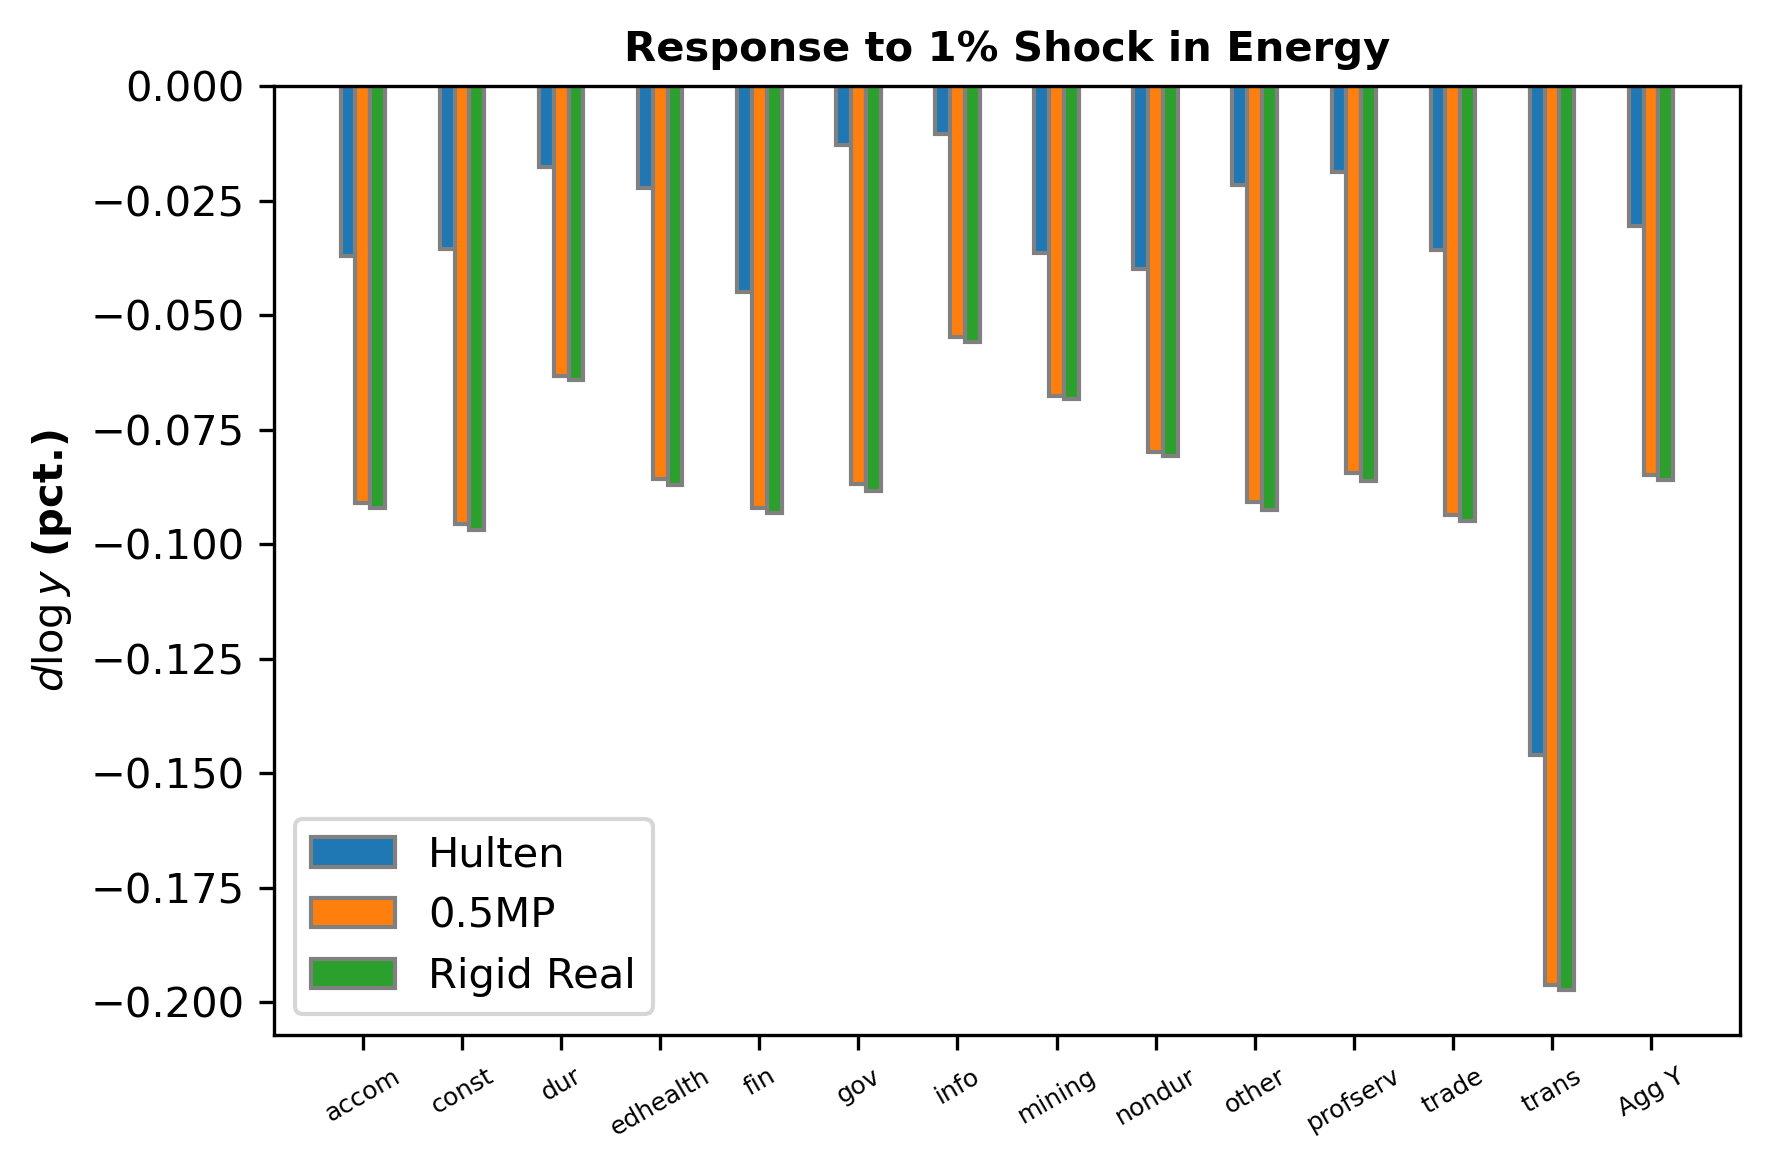

In [15]:
title = f'Response to 1% Shock in Energy'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_KshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

In [16]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

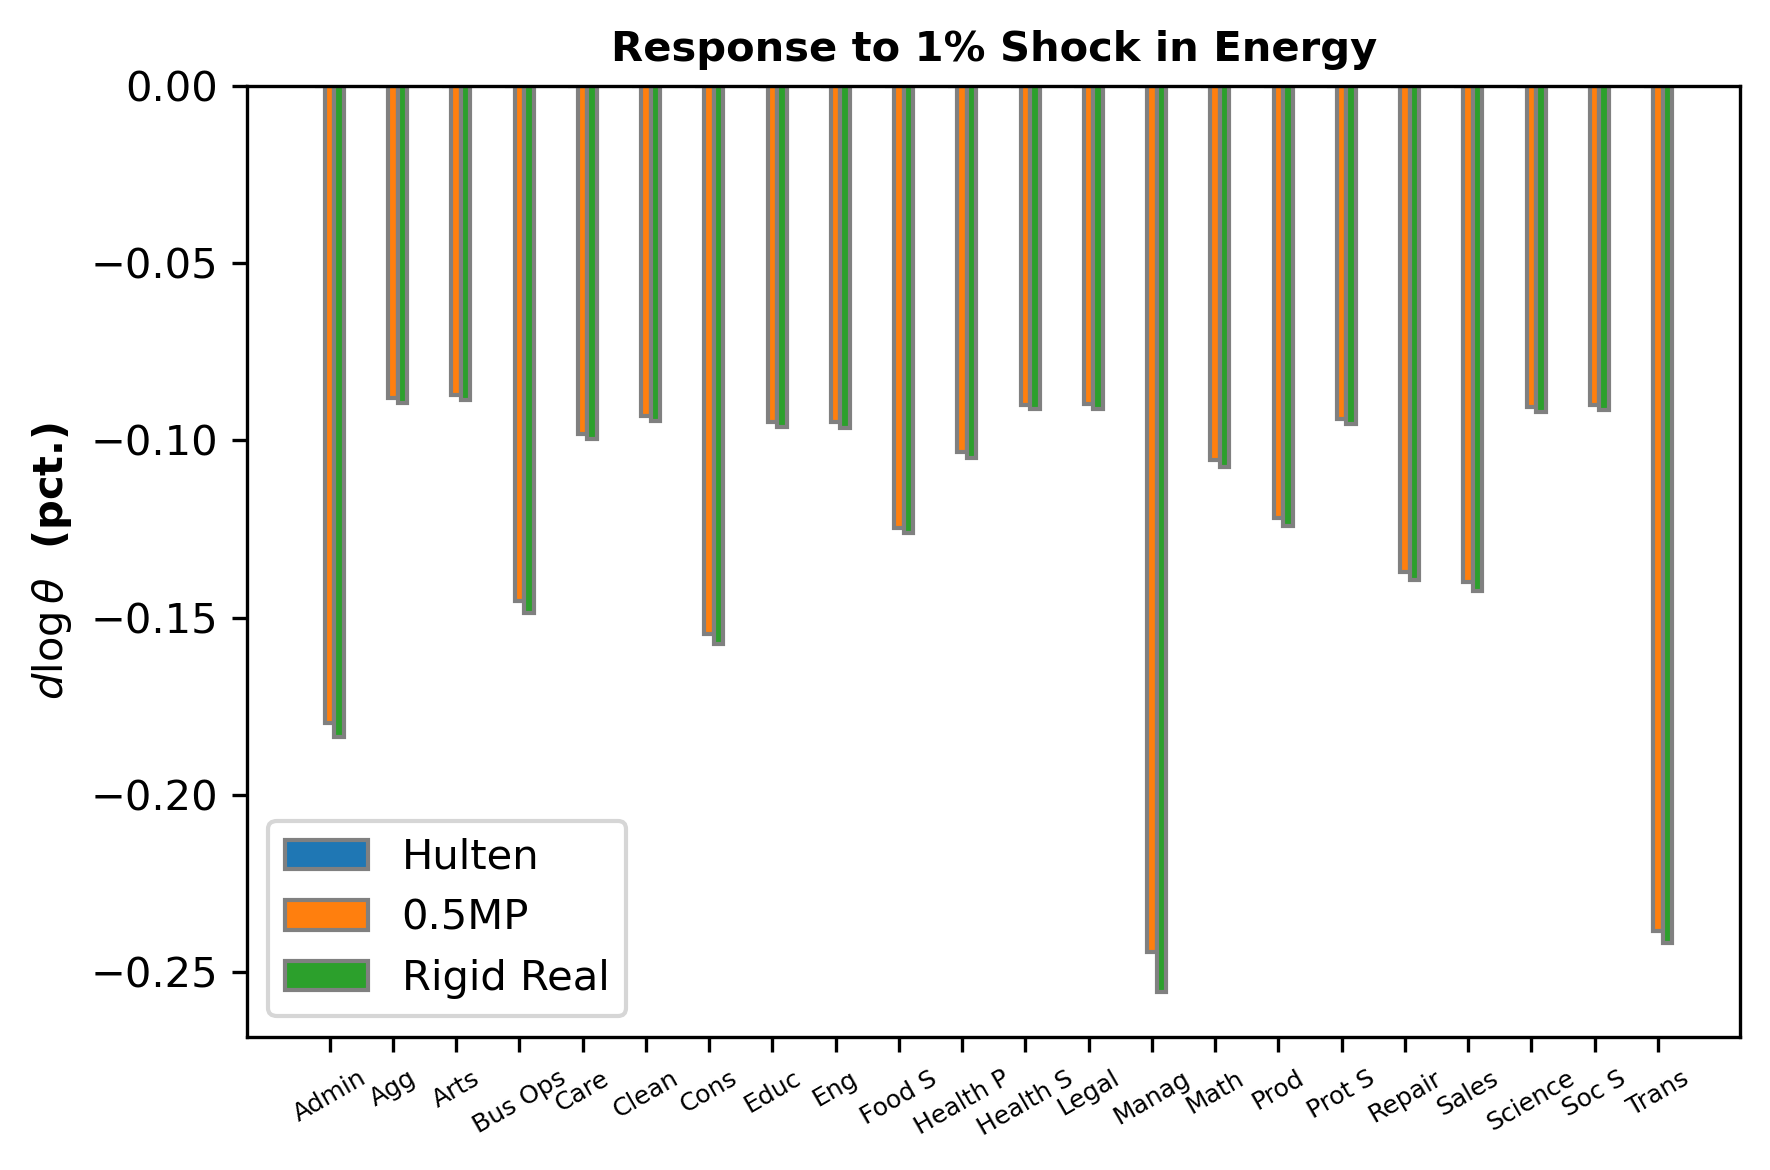

In [17]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_KshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

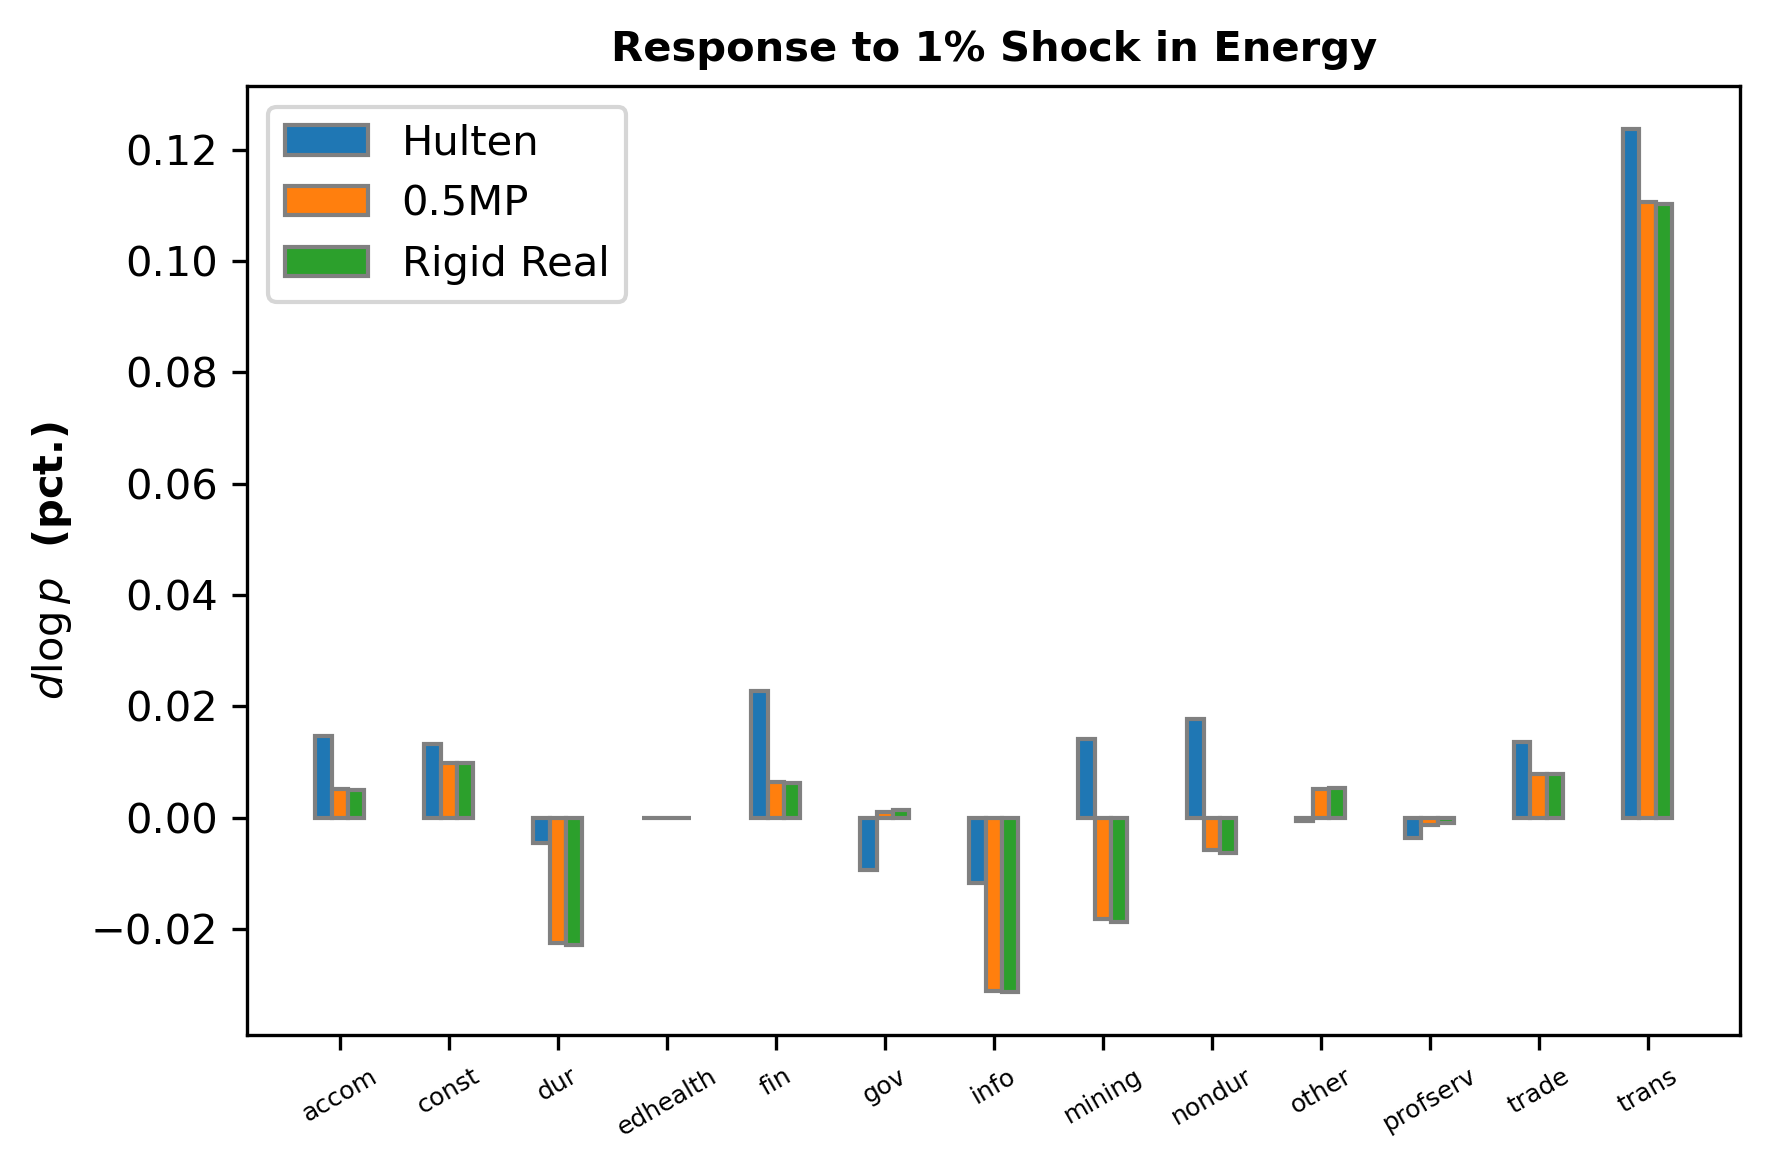

In [18]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_KshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

## Labor Supply Shocks to Service Sectors

In [19]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

In [20]:
occupation_names.index('Care')

4

In [21]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
service_sectors = ['Care', 'Clean', 'Food S', 'Trans']
shock_size = -0.01

for i in service_sectors:
    dlog_H[occupation_names.index(i)] = shock_size
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
secT_vec = np.zeros((J, len(PriceAssumption)))

occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [22]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [23]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta, curlyL), axis=0)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [24]:
sectorY_vec.shape

(14, 2)

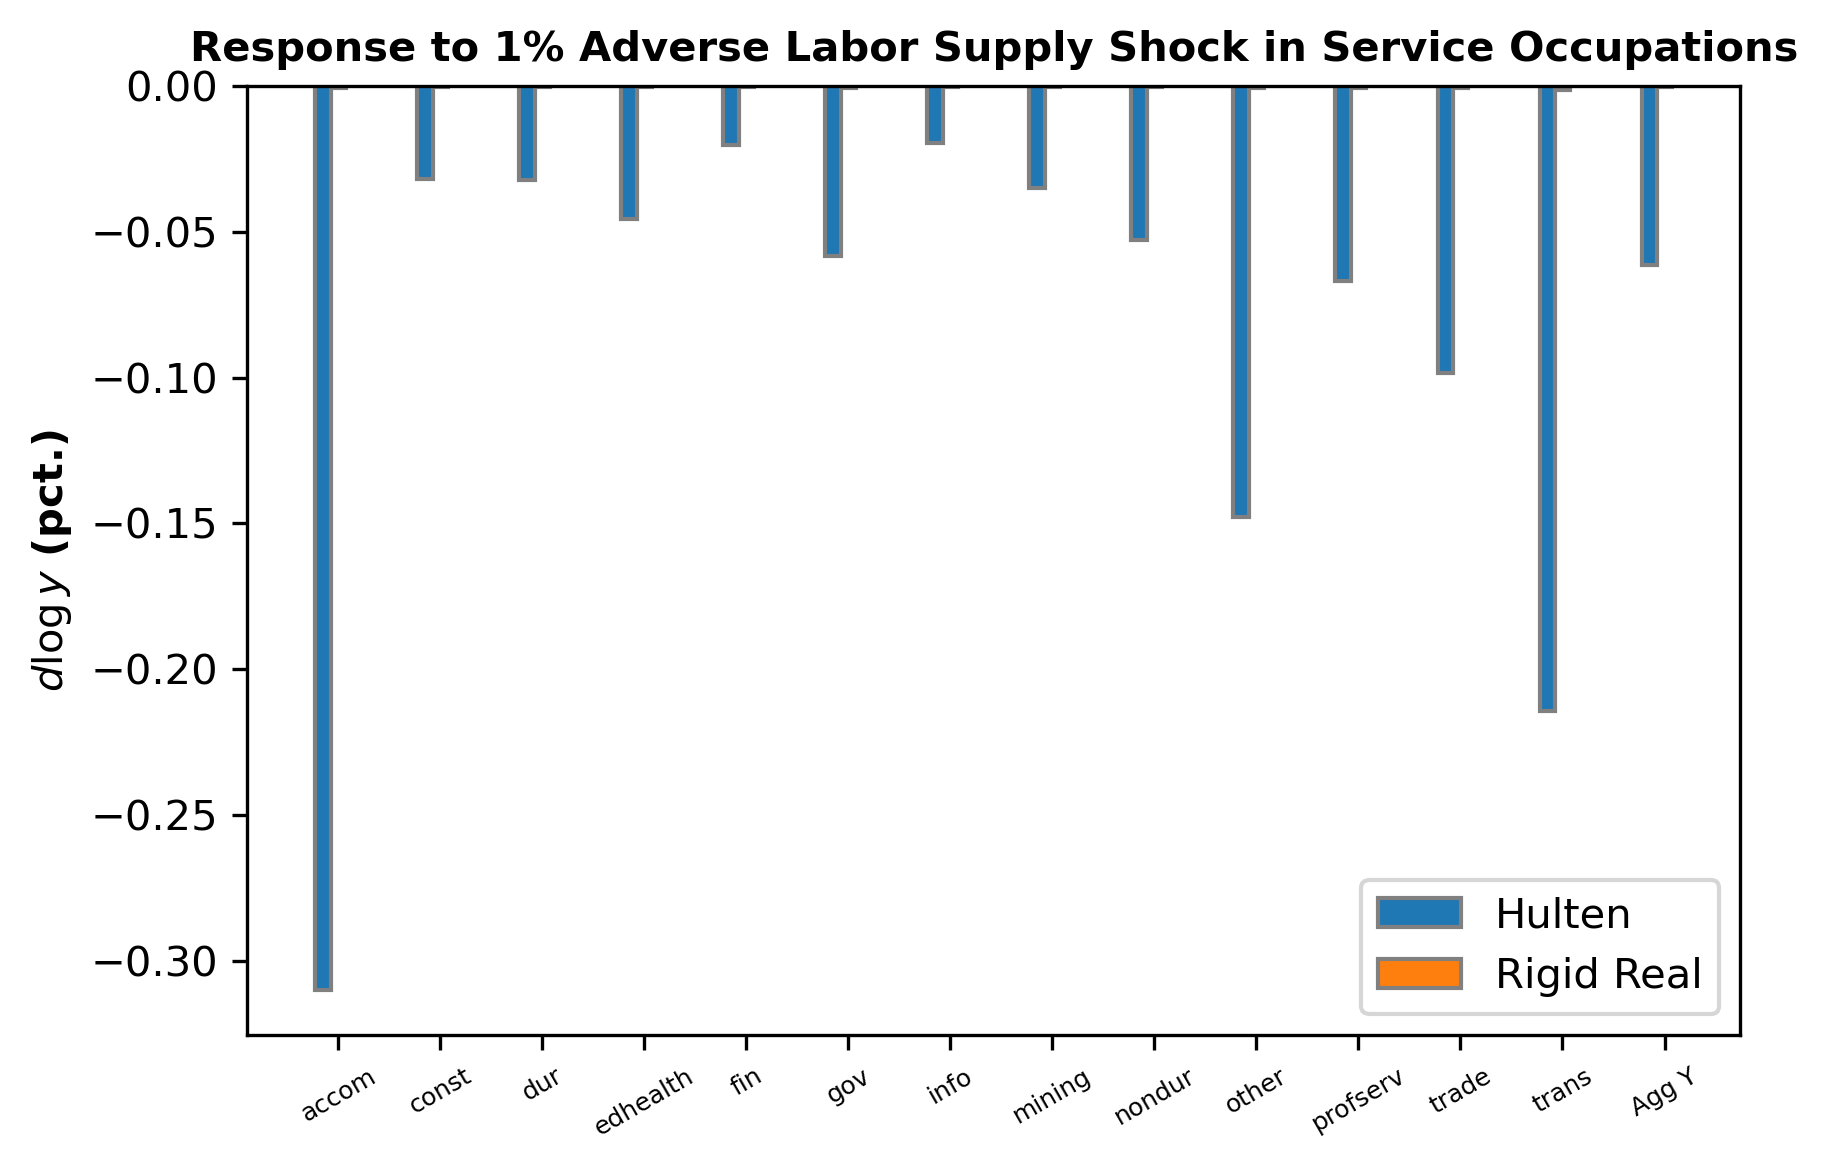

In [25]:
title = f'Response to 1% Adverse Labor Supply Shock in Service Occupations'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

In [26]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

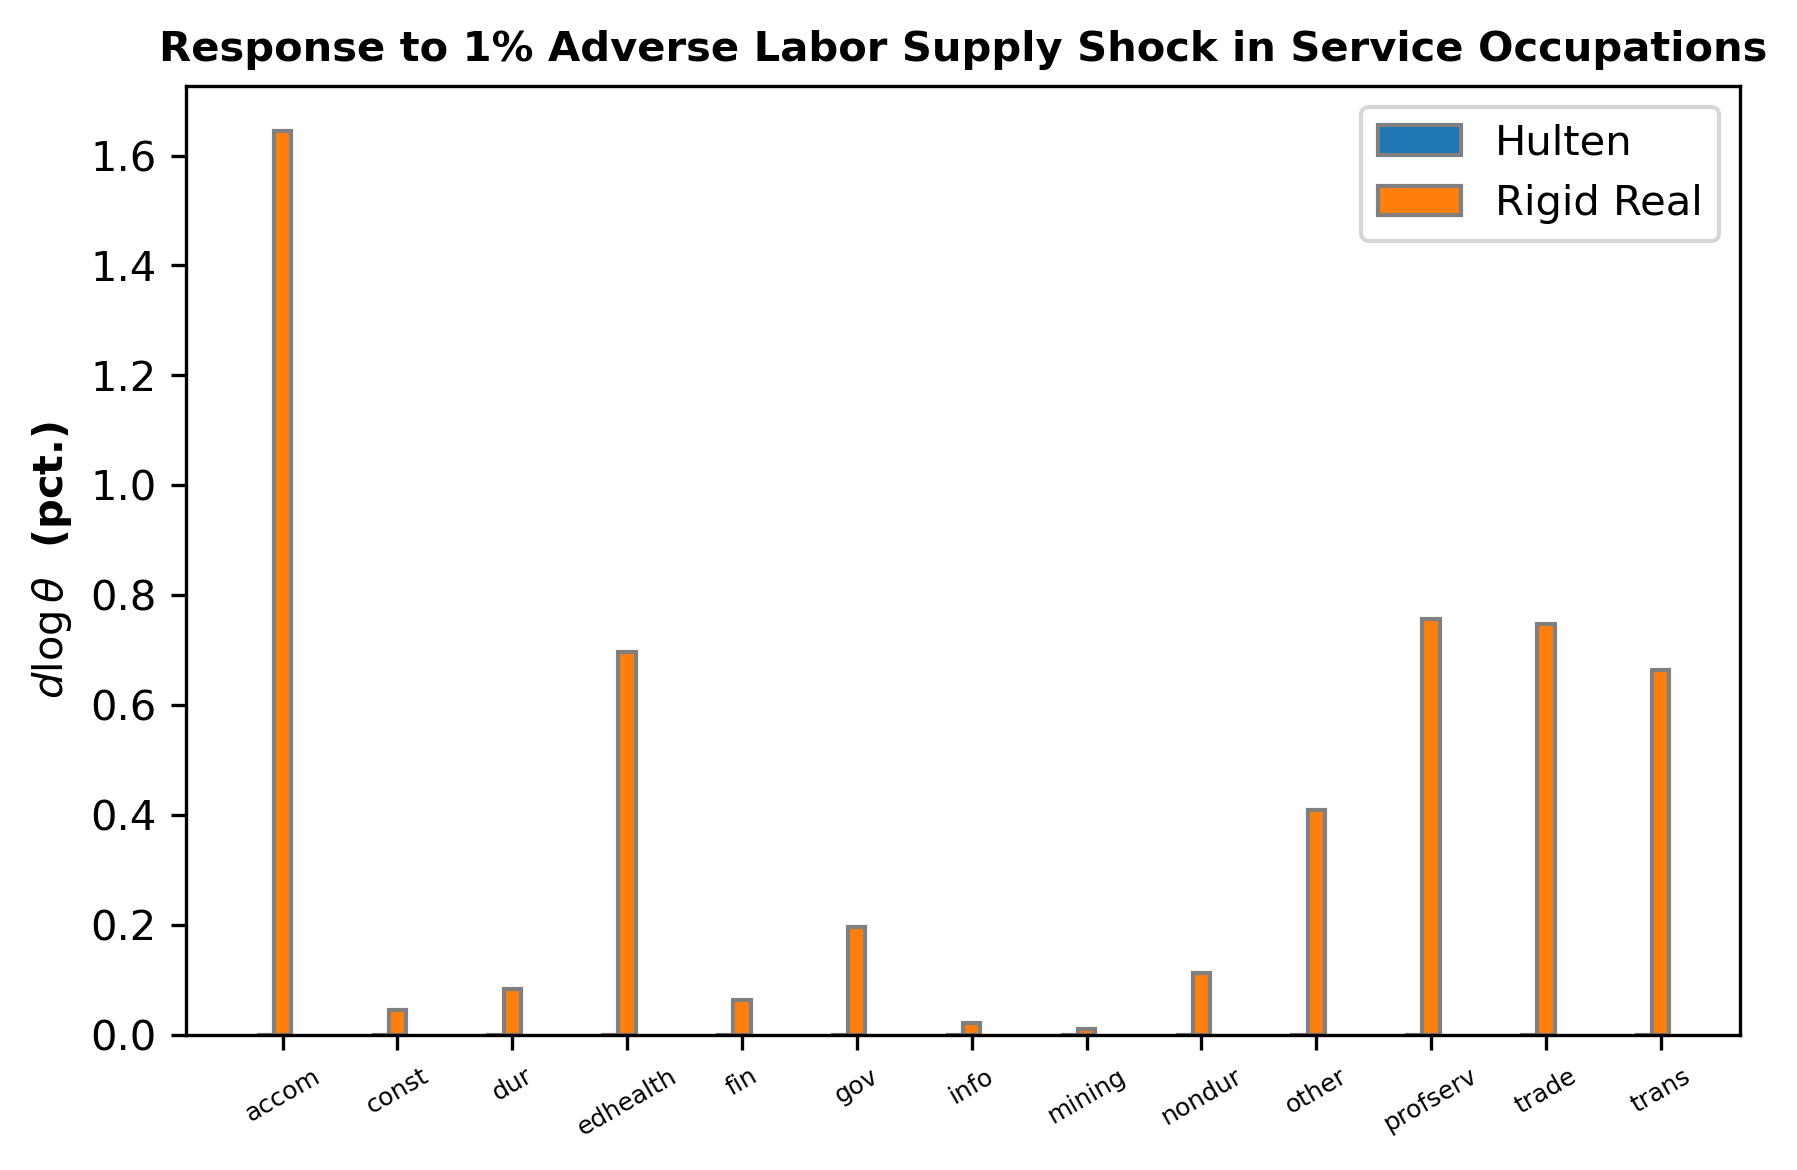

In [27]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockTsec_calib3.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

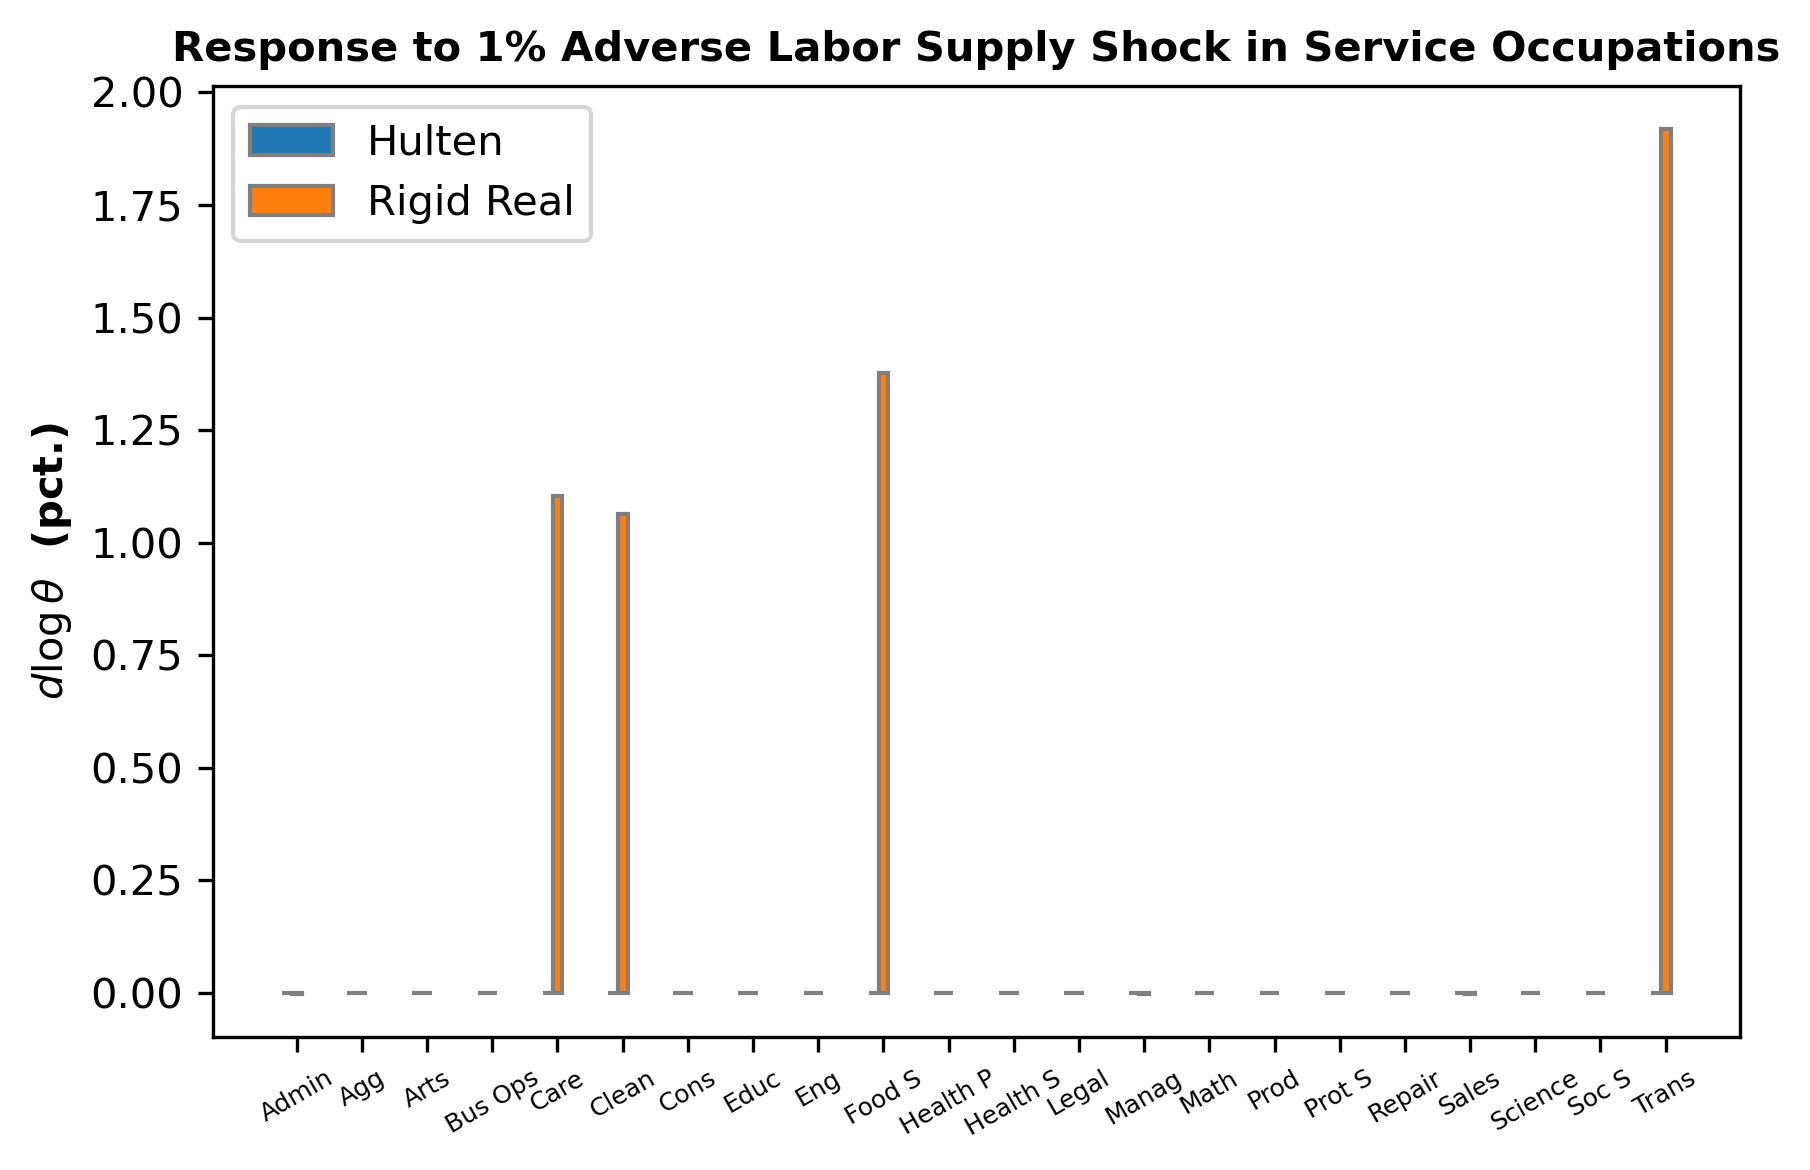

In [28]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

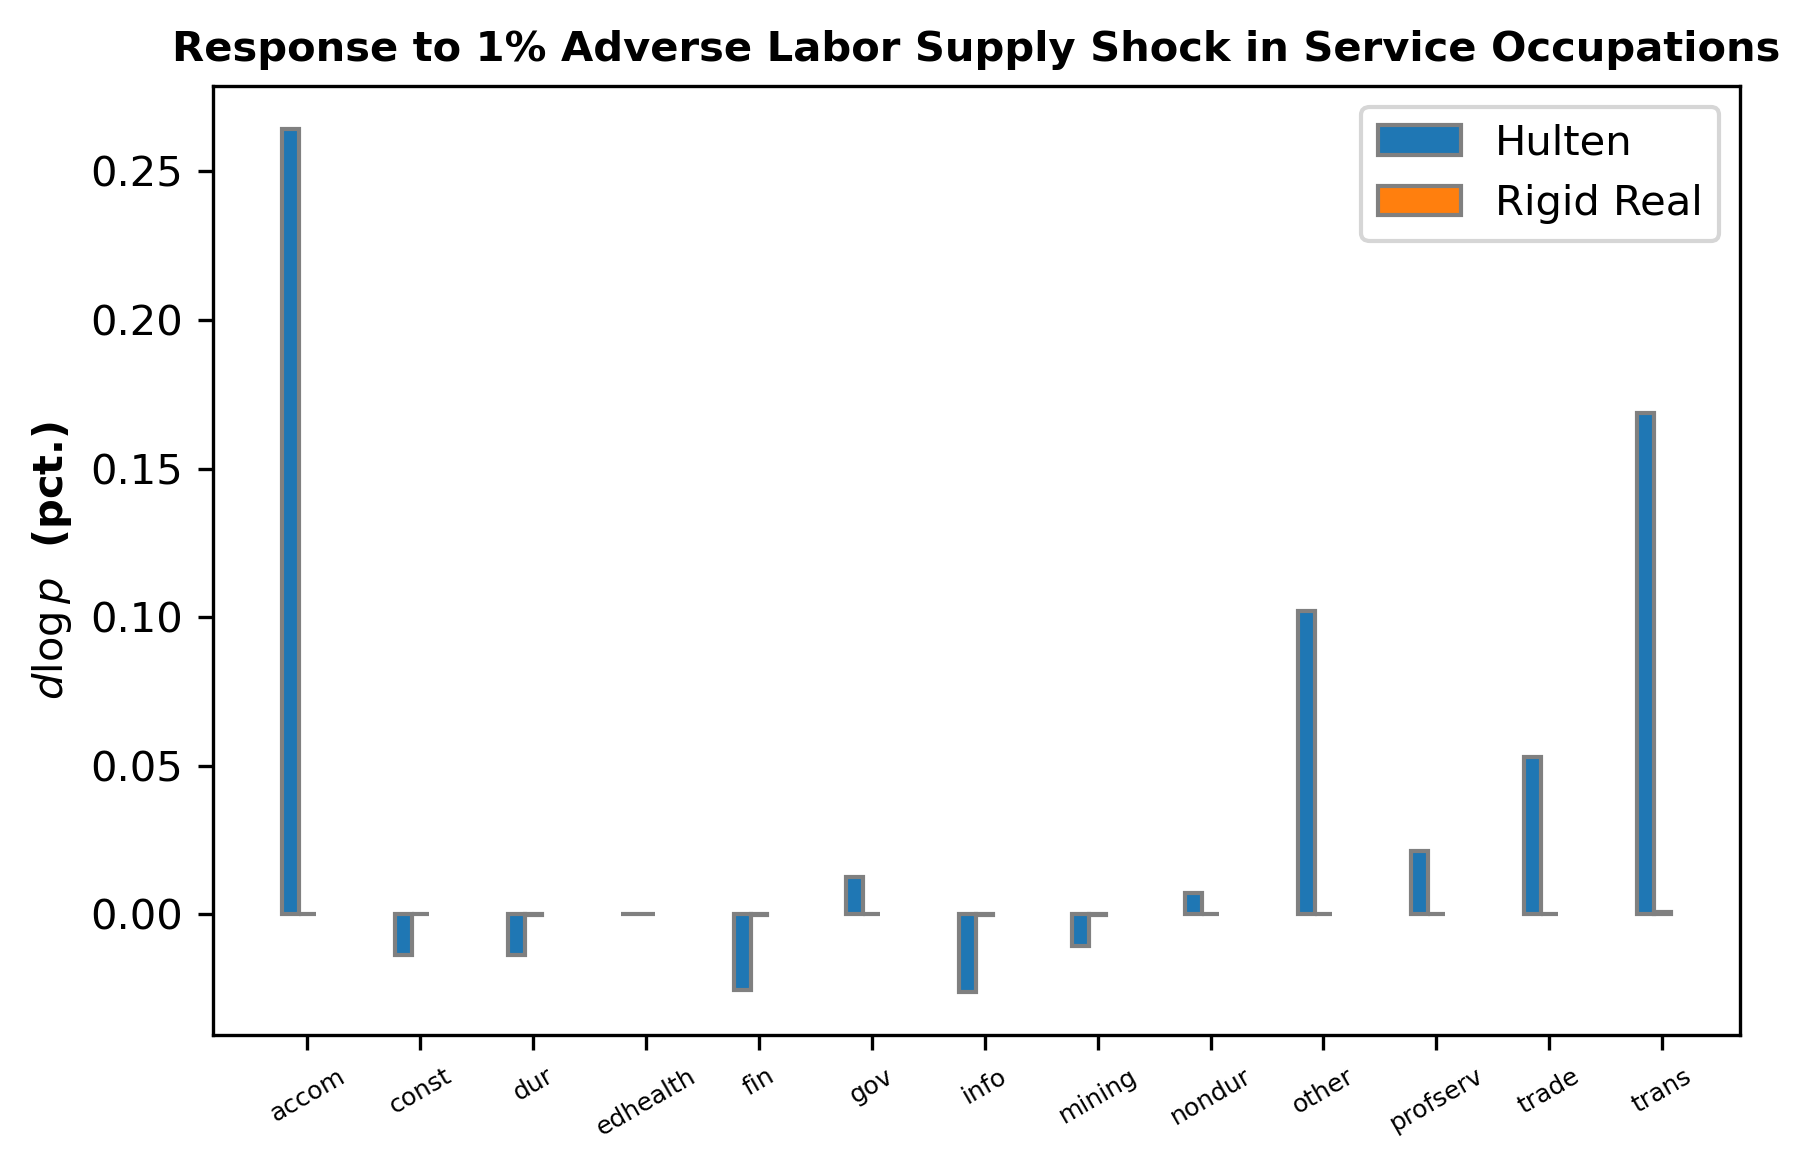

In [29]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

## Calibration figures: Response to Labor Supply Shock

### Aggregate importance of deviations from Hulten.

To analyse the quantitative importance of deviations from Hulten's theorem, below we vary $\gamma_A$ from 0 to 2, and plot the aggregate response to a 1\% shock to durable goods.

In [30]:
dlog_A = np.zeros((J, 1))
dlog_H = np.ones((O, 1)) * -0.01
dlog_K = np.zeros((K, 1))
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
secT_vec = np.zeros((J, len(PriceAssumption))) 
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [31]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [32]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta, curlyL), axis=0)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [33]:
sectorY_vec.shape

(14, 2)

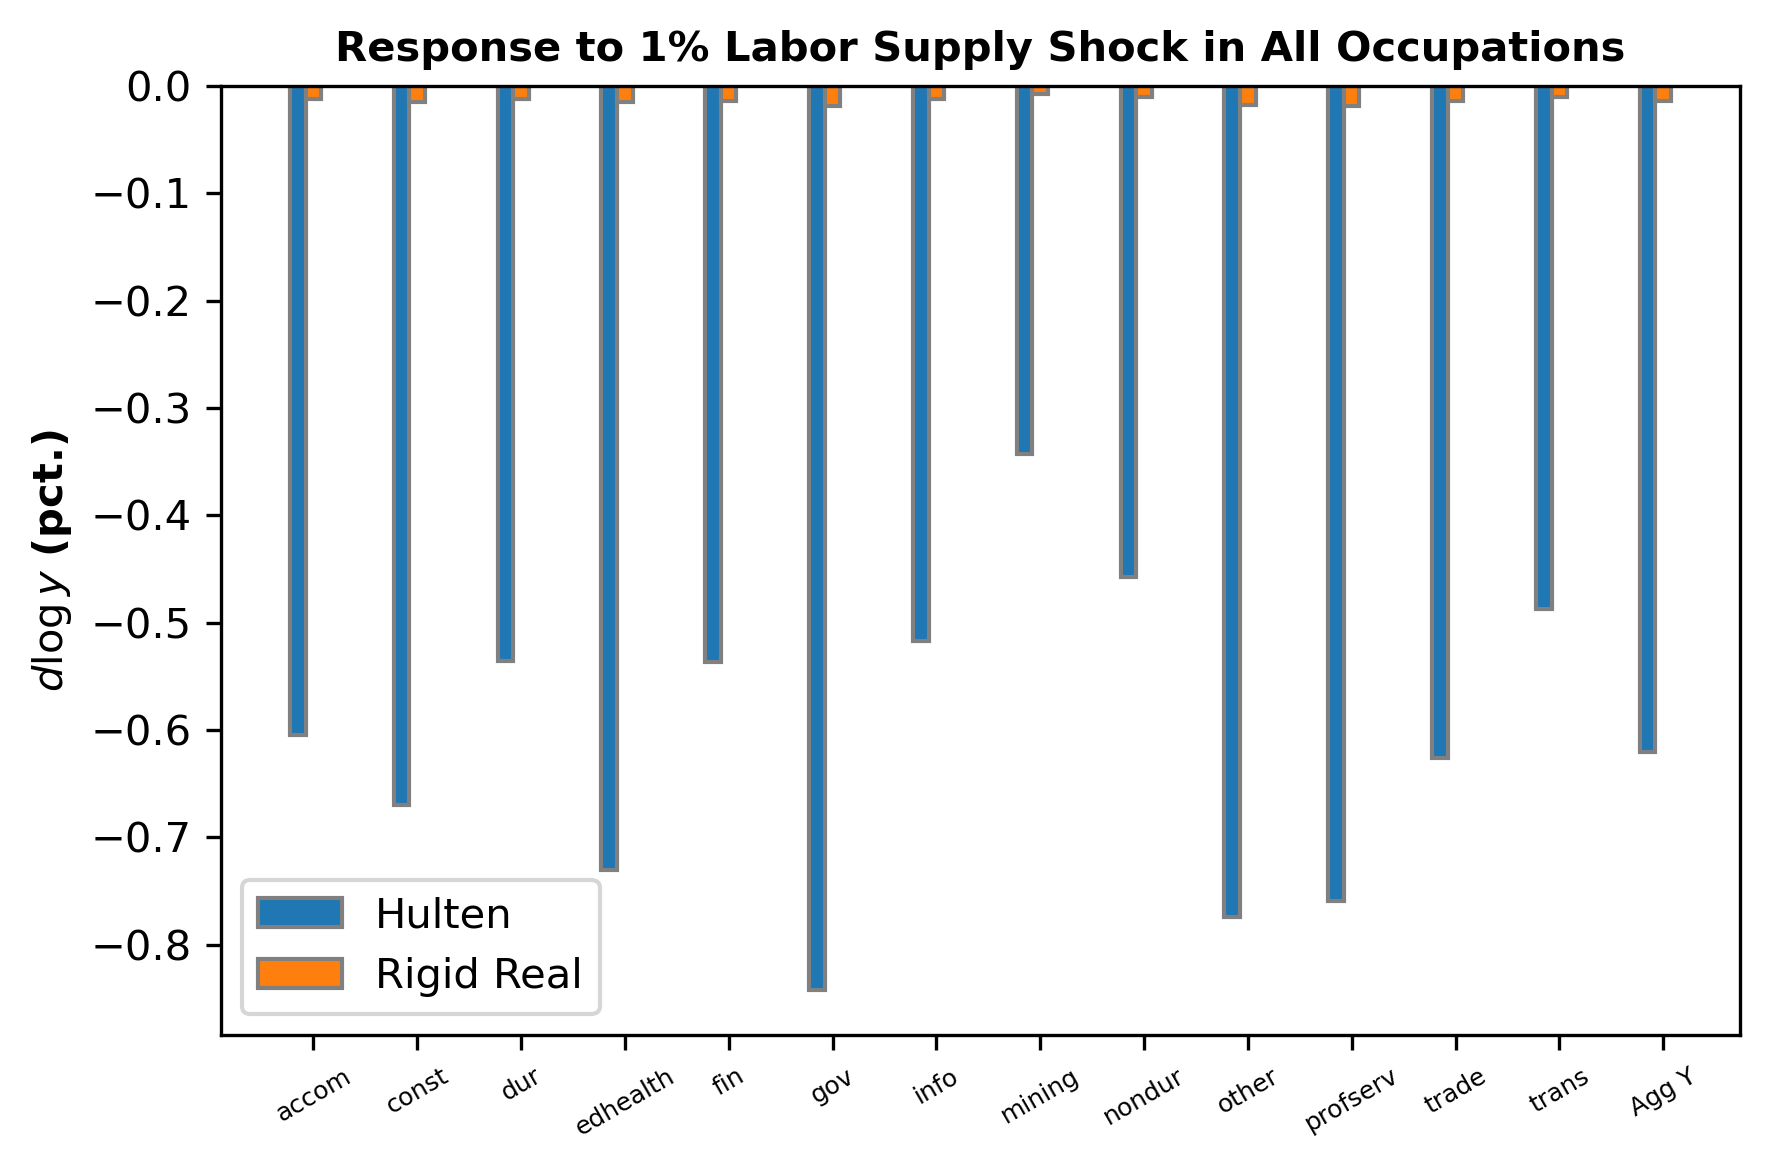

In [34]:
title = f'Response to 1% Labor Supply Shock in All Occupations'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

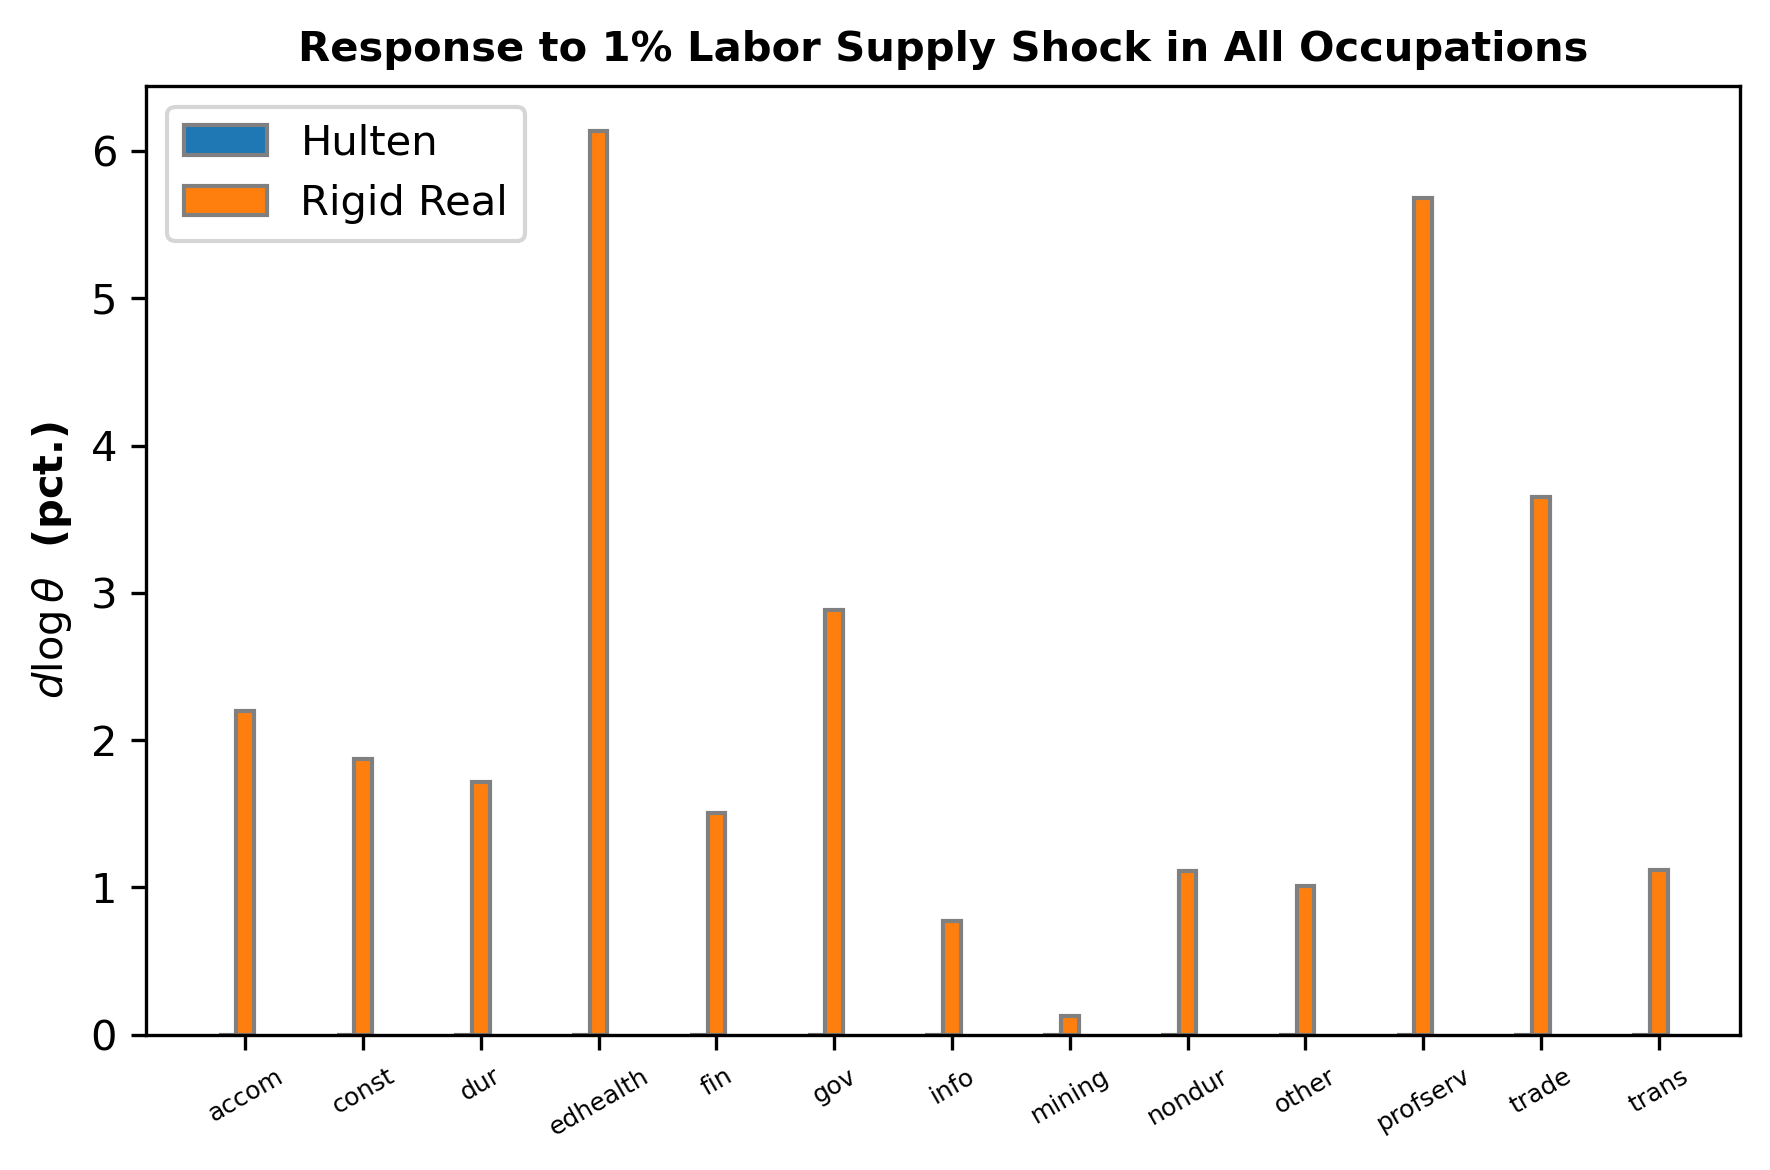

In [35]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockTsec_calib3.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

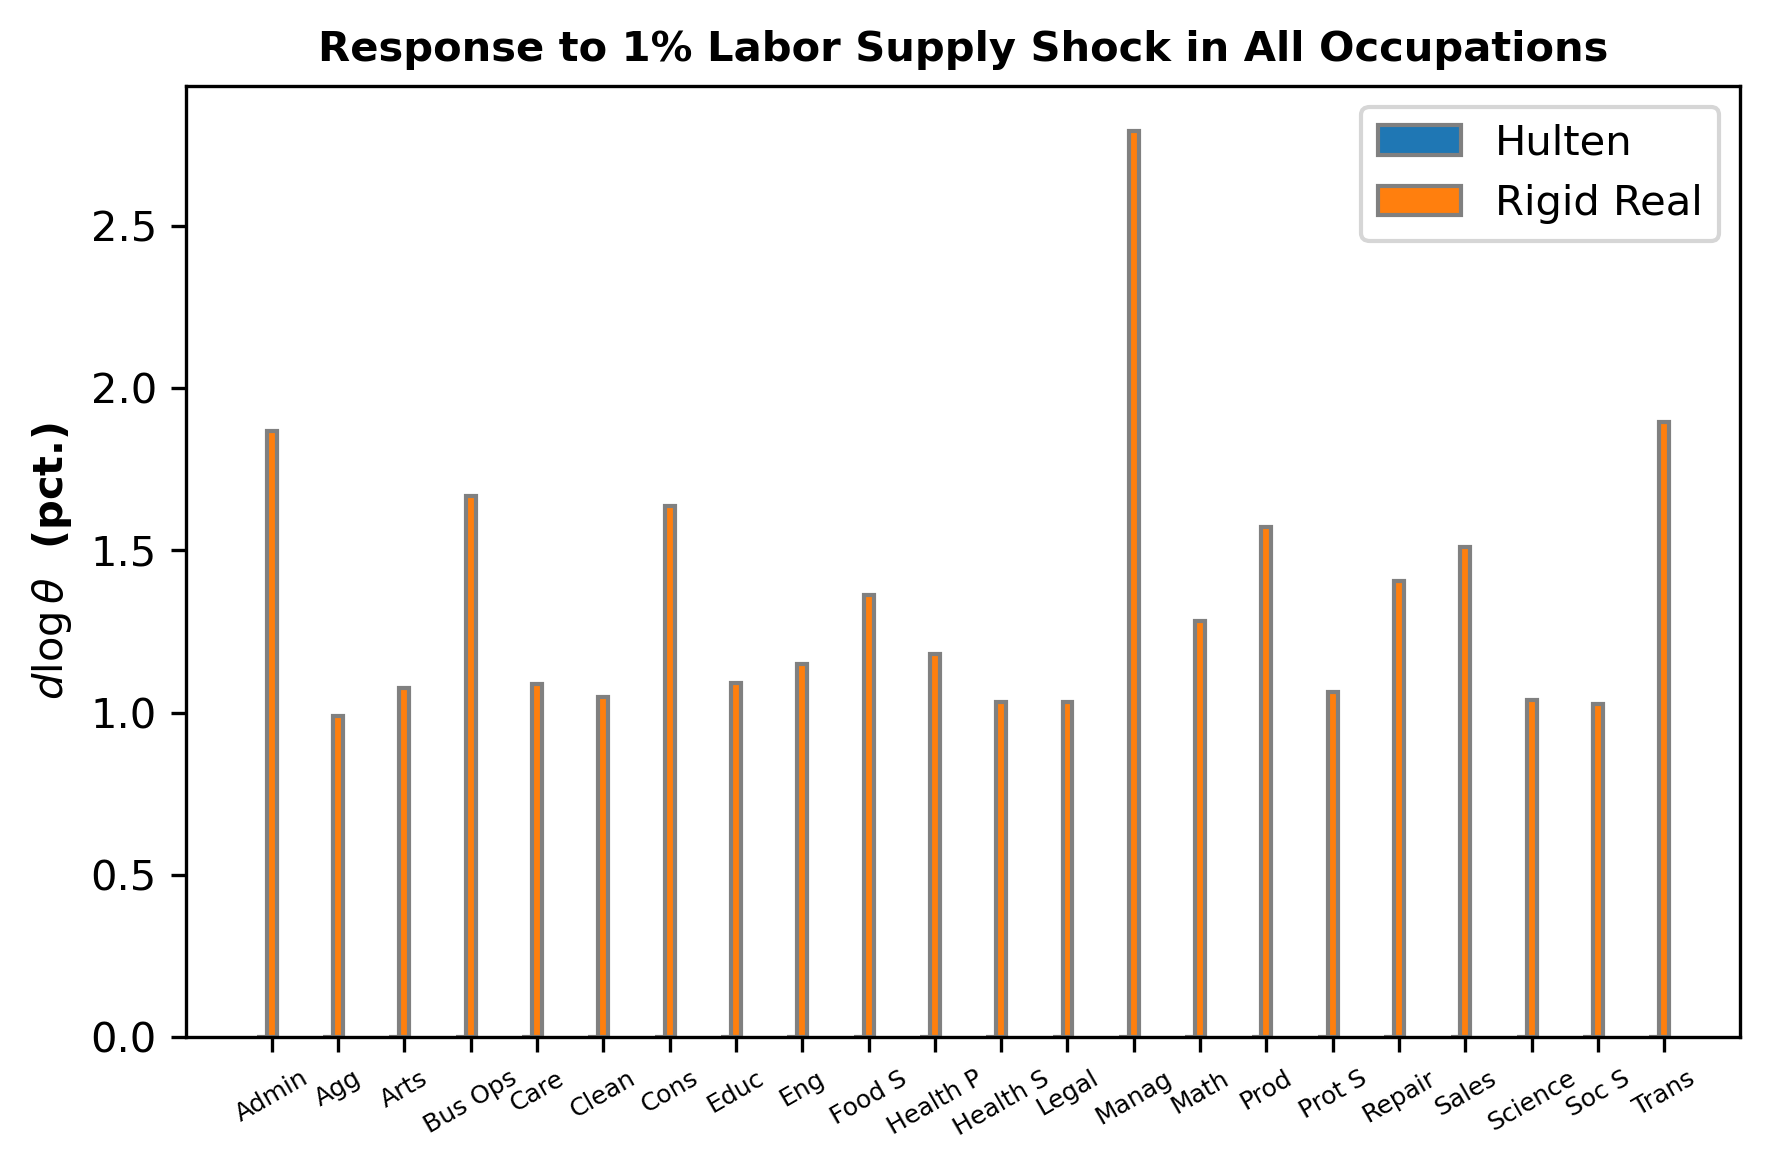

In [36]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

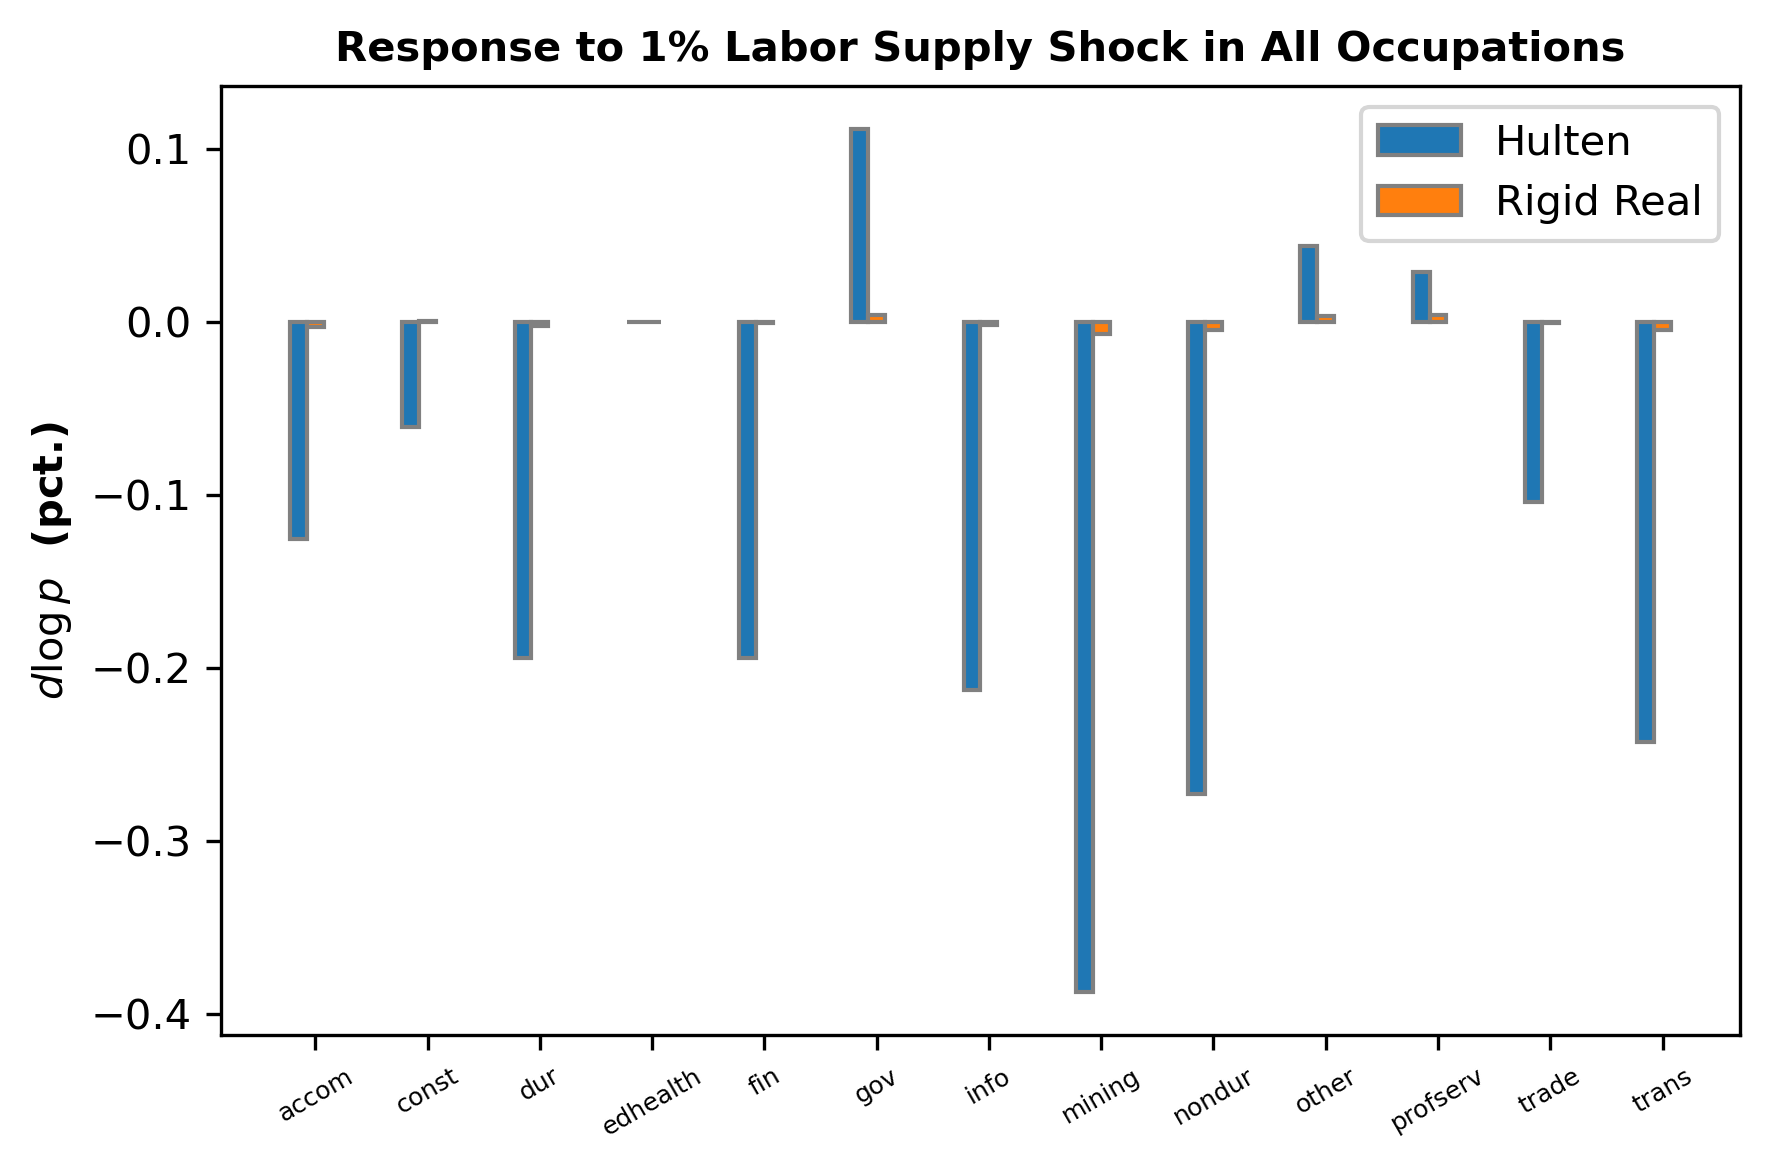

In [37]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

# Combination Shocks

In [38]:
dlog_A = np.zeros((J, 1))
dlog_H = np.ones((O, 1)) * -0.01
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.01
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [39]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [40]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [41]:
sectorY_vec.shape

(14, 2)

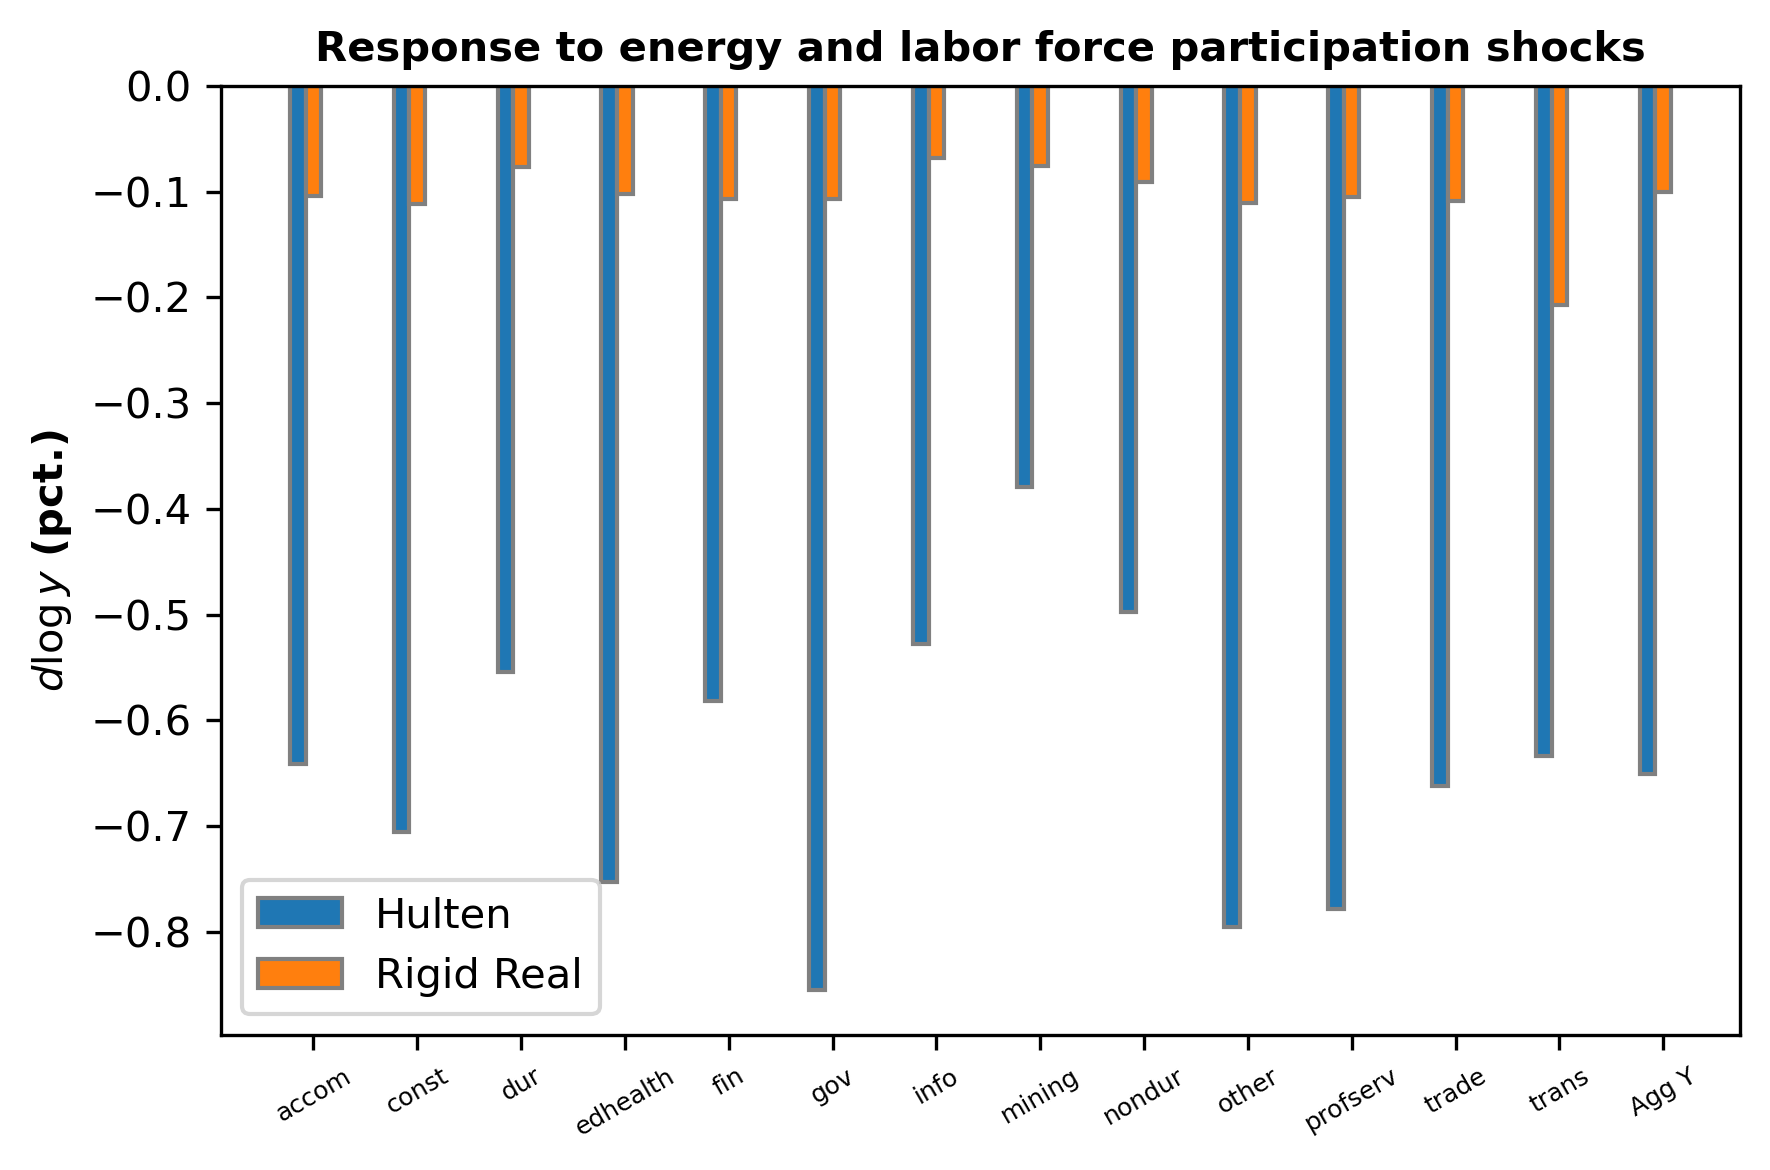

In [42]:
title = f'Response to energy and labor force participation shocks'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HKshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

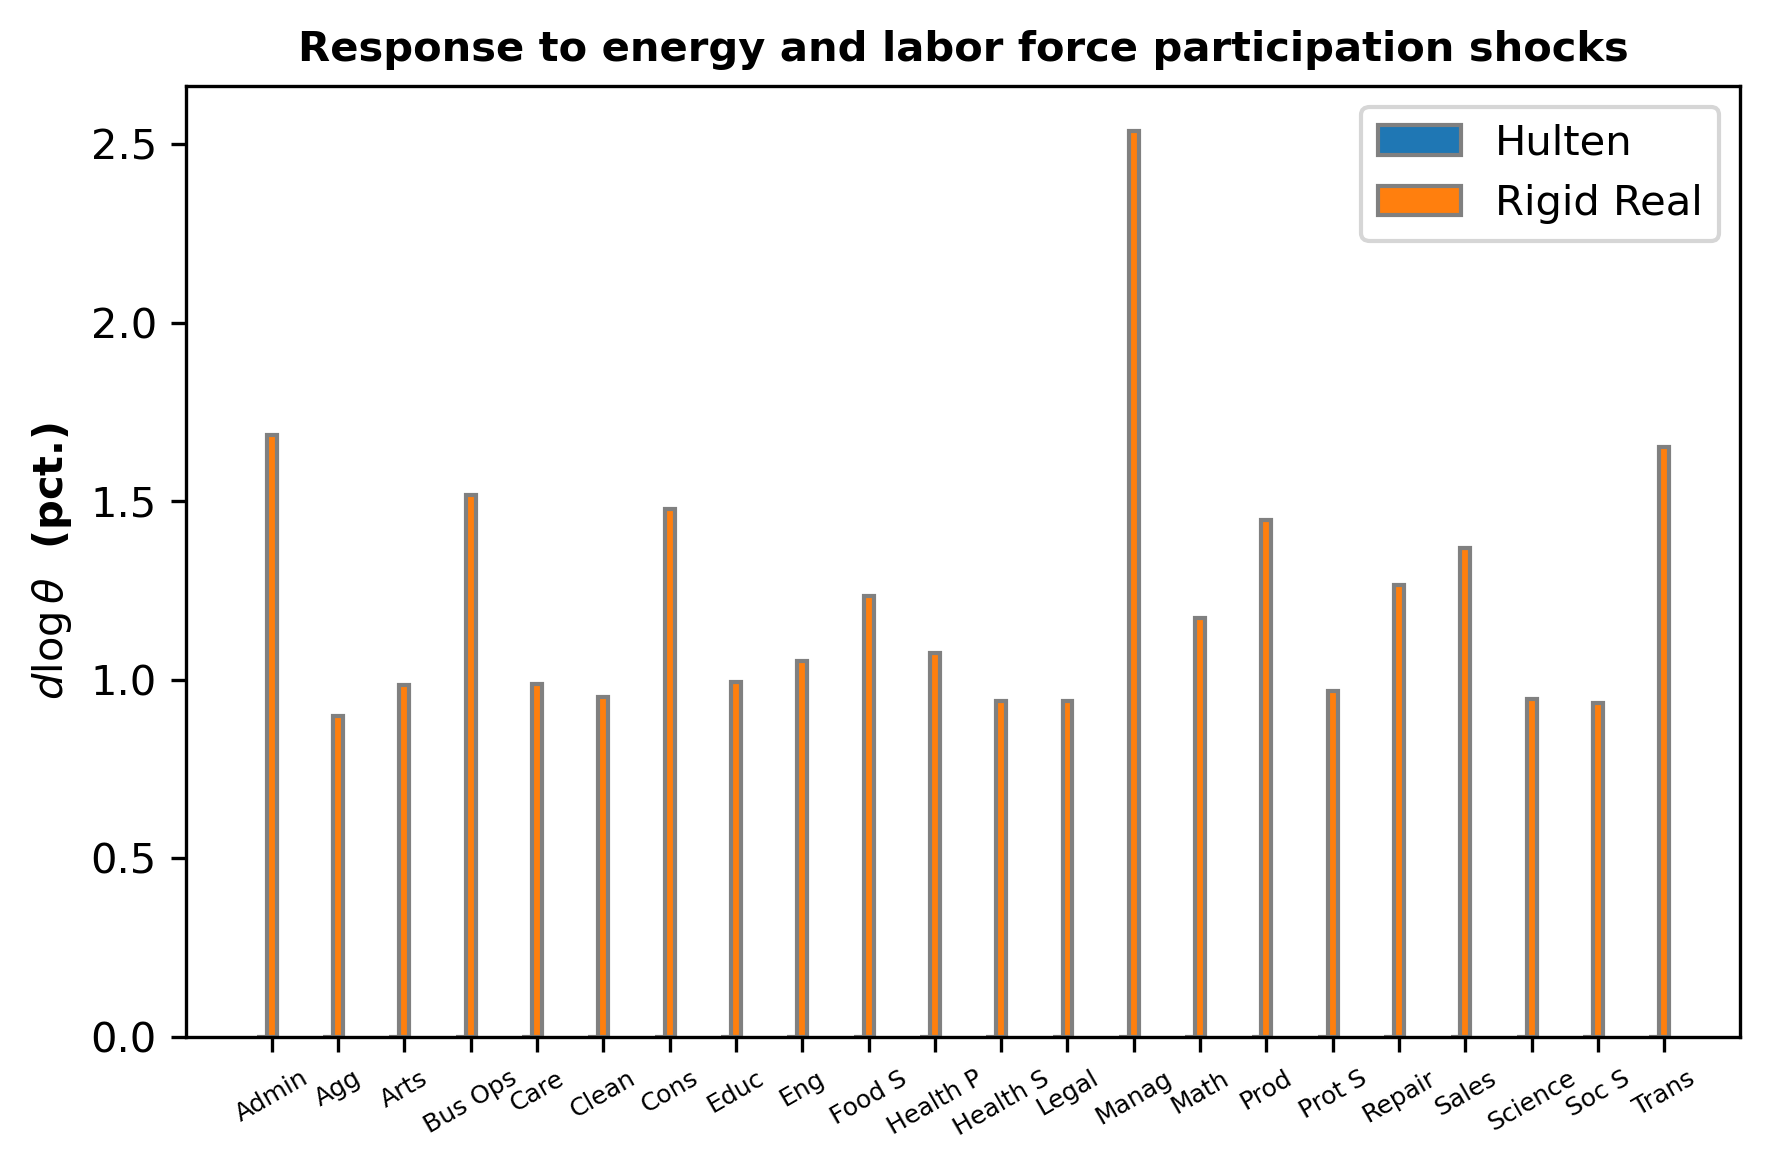

In [43]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HKshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

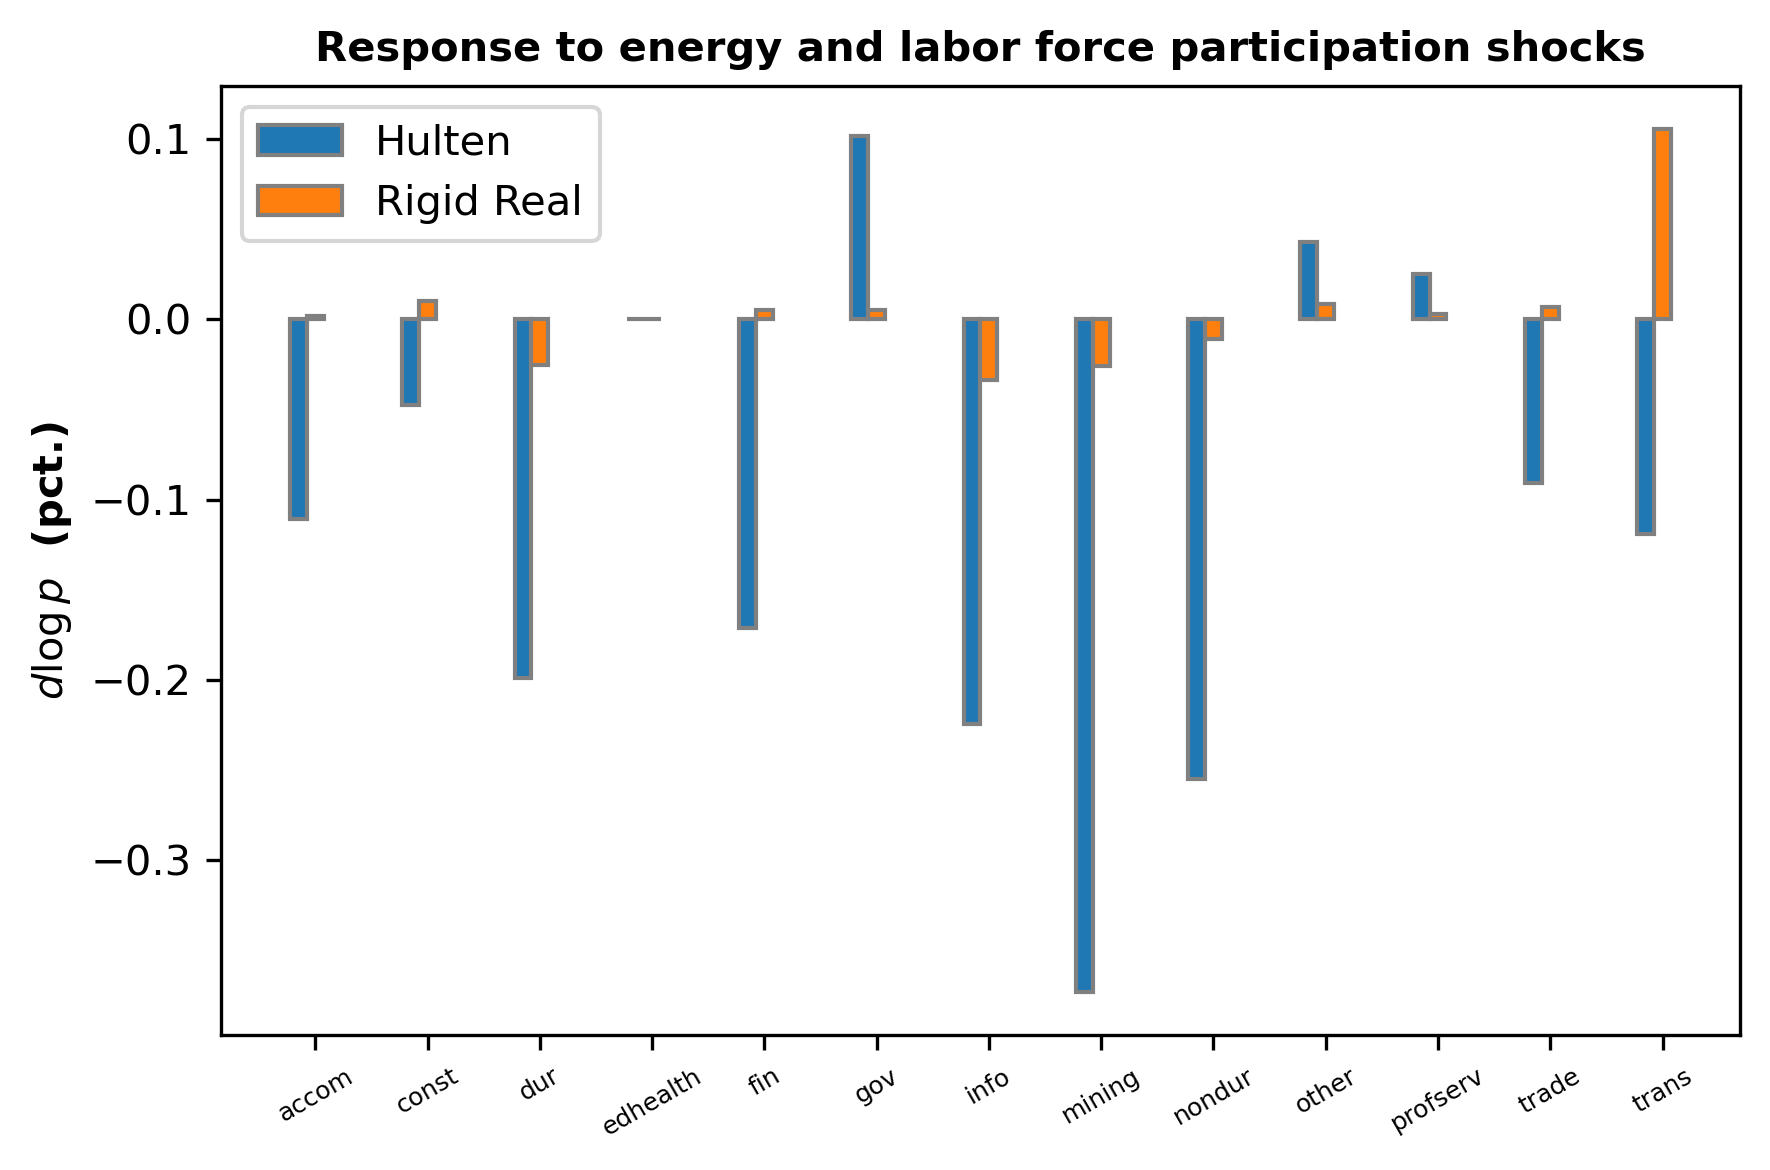

In [44]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HKshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)